# Comparando matrices G y H con ambos métodos

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from FMM_BEM import read_geo_and_create_quadtree, surf_plot, eval_sol, upward_pass, downward_pass, m2l_translation

from numpy import log, sin, cos, arctan2, pi, mean
from numpy.linalg import norm, solve


In [24]:
# Parámetros de la geometría
num_points = 100  # Número de puntos en el borde
radius = 0.1
theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
coords = np.vstack((radius * np.cos(theta), radius * np.sin(theta))).T

# Define la conectividad en segmentos (para un círculo cerrado)
elems = np.array([(i, (i + 1) % num_points) for i in range(num_points)])


In [25]:
# Función de cálculo directo BEM clásico
def compute_classic_bem(coords, elems):
    nelems = elems.shape[0]
    Gmat = np.zeros((nelems, nelems))
    Hmat = np.zeros((nelems, nelems))
    
    for i, elem1 in enumerate(elems):
        pt1 = np.mean(coords[elem1], axis=0)
        for j, elem2 in enumerate(elems):
            pt2 = np.mean(coords[elem2], axis=0)
            if i == j:
                # Auto-interacción (aproximación simple para el ejemplo)
                Gmat[i, j] = -1 / (2 * np.pi) * np.log(np.linalg.norm(coords[elem1[1]] - coords[elem1[0]]) / 2)
                Hmat[i, j] = -0.5
            else:
                # Interacción directa entre elementos distintos
                d = np.linalg.norm(pt1 - pt2)
                Gmat[i, j] = 1 / (2 * np.pi * d)
                Hmat[i, j] = -1 / (2 * np.pi * d ** 2)
                
    return Gmat, Hmat

# Función de cálculo usando FMM-BEM
def compute_fmm_bem(coords, elems, quadtree, order):
    nelems = elems.shape[0]
    Gmat = np.zeros((nelems, nelems))
    Hmat = np.zeros((nelems, nelems))
    
    # Realizar las fases ascendente y descendente del FMM
    upward_pass(quadtree, order)
    downward_pass(quadtree, order)
    
    for i, elem1 in enumerate(elems):
        pt1 = np.mean(coords[elem1], axis=0)
        for j, elem2 in enumerate(elems):
            pt2 = np.mean(coords[elem2], axis=0)
            
            # Localizar las celdas en el quadtree
            node_info1 = quadtree.find_point_location(pt1)
            node_info2 = quadtree.find_point_location(pt2)
            node1 = node_info1['leaf']
            node2 = node_info2['leaf']
            
            if node1 == node2 or node1.is_adjacent(node2):
                # Interacciones cercanas
                if i == j:
                    # Auto-interacción
                    Gmat[i, j] = -1 / (2 * np.pi) * np.log(np.linalg.norm(coords[elem1[1]] - coords[elem1[0]]) / 2)
                    Hmat[i, j] = -0.5
                else:
                    # Interacción directa
                    d = np.linalg.norm(pt1 - pt2)
                    Gmat[i, j] = 1 / (2 * np.pi * d)
                    Hmat[i, j] = -1 / (2 * np.pi * d ** 2)
            else:
                # Interacciones lejanas usando FMM (simplificación para ilustración)
                dx = node1.center[0] - node2.center[0]
                dy = node1.center[1] - node2.center[1]
                local_expansion = m2l_translation(node2.multipole_moments, dx, dy, order)
                z = complex(pt1[0] - node1.center[0], pt1[1] - node1.center[1])
                potential = sum(coeff * (z**k) for k, coeff in enumerate(local_expansion))
                Gmat[i, j] += np.real(potential) / (2 * np.pi)
                Hmat[i, j] += np.imag(potential) / (2 * np.pi)
    
    return Gmat, Hmat



In [26]:
# Ejecución y comparación
# Crear el quadtree y definir el orden de expansión
from quadtree import Quadtree  # Importa el quadtree implementado
quadtree = Quadtree(bounds=[-1.5, -1.5, 1.5, 1.5], points=coords, max_points=1, max_depth=5)
order = 10


In [27]:

G_classic, H_classic = compute_classic_bem(coords, elems)


In [28]:
G_fmm, H_fmm = compute_fmm_bem(coords, elems, quadtree, order)


In [29]:

# Comparación de resultados
print("Diferencias en la matriz G:")
print(np.abs(G_classic - G_fmm))

print("\nDiferencias en la matriz H:")
print(np.abs(H_classic - H_fmm))


Diferencias en la matriz G:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Diferencias en la matriz H:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


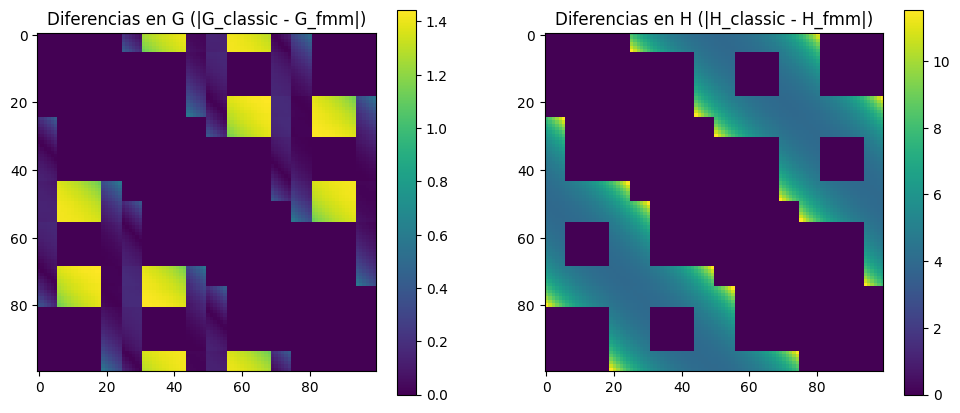

In [30]:

# Visualización de diferencias
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(G_classic - G_fmm), cmap='viridis')
plt.colorbar()
plt.title("Diferencias en G (|G_classic - G_fmm|)")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(H_classic - H_fmm), cmap='viridis')
plt.colorbar()
plt.title("Diferencias en H (|H_classic - H_fmm|)")

plt.show()

Cuando se deja la función de la IA tal cual se obtiene una diferencia de 0.0 entre las matrices $G$ y $H$, pero cuando se incluye la función de coeficientes de influencia, se empieza a observar una diferencia notable.

# Usando función de Nicolás

In [31]:
def influence_coeff(elem, coords, pt_col):
    """Compute influence coefficients

    Parameters
    ----------
    elems : ndarray, int
        Connectivity for the elements.
    coords : ndarray, float
        Coordinates for the nodes.
    pt_col : ndarray
        Coordinates of the colocation point.

    Returns
    -------
    G_coeff : float
        Influence coefficient for flows.
    H_coeff : float
        Influence coefficient for primary variable.
    """
    dcos = coords[elem[1]] - coords[elem[0]]
    dcos = dcos / norm(dcos)
    rotmat = np.array([[dcos[1], -dcos[0]],
                       [dcos[0], dcos[1]]])
    r_A = rotmat.dot(coords[elem[0]] - pt_col)
    r_B = rotmat.dot(coords[elem[1]] - pt_col)
    theta_A = arctan2(r_A[1], r_A[0])
    theta_B = arctan2(r_B[1], r_B[0])
    if norm(r_A) <= 1e-6:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0]
    elif norm(r_B) <= 1e-6:
        G_coeff = -(r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    else:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0] -\
                  (r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    H_coeff = theta_B - theta_A
    return -G_coeff/(2*pi), H_coeff/(2*pi)


def assem(coords, elems):
    """Assembly matrices for the BEM problem

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.

    Returns
    -------
    Gmat : ndarray, float
        Influence matrix for the flow.
    Hmat : ndarray, float
        Influence matrix for primary variable.
    """
    nelems = elems.shape[0]
    Gmat = np.zeros((nelems, nelems))
    Hmat = np.zeros((nelems, nelems))
    for ev_cont, elem1 in enumerate(elems):
        for col_cont, elem2 in enumerate(elems):
            pt_col = mean(coords[elem2], axis=0)
            if ev_cont == col_cont:
                L = norm(coords[elem1[1]] - coords[elem1[0]])
                Gmat[ev_cont, ev_cont] = - L/(2*pi)*(log(L/2) - 1)
                Hmat[ev_cont, ev_cont] = - 0.5
            else:
                Gij, Hij = influence_coeff(elem1, coords, pt_col)
                Gmat[ev_cont, col_cont] = Gij
                Hmat[ev_cont, col_cont] = Hij
    return Gmat, Hmat

In [32]:
G_classic_nico, H_classic_nico = assem(coords, elems)


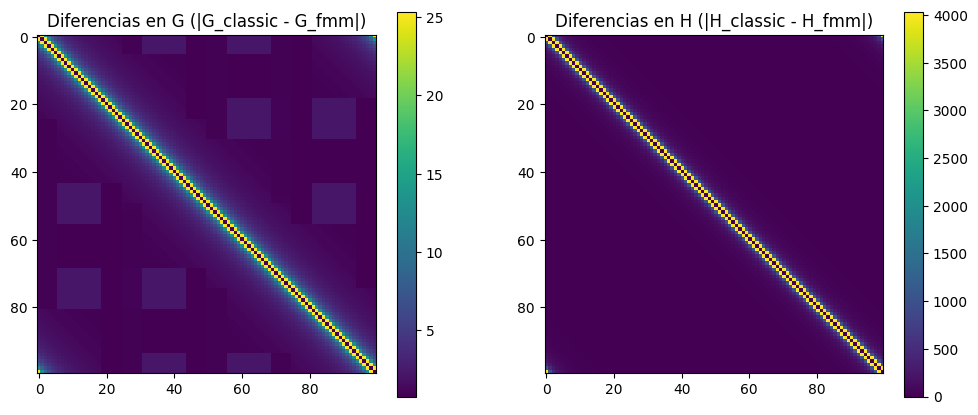

In [33]:

# Visualización de diferencias
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(G_classic_nico - G_fmm), cmap='viridis')
plt.colorbar()
plt.title("Diferencias en G (|G_classic - G_fmm|)")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(H_classic_nico - H_fmm), cmap='viridis')
plt.colorbar()
plt.title("Diferencias en H (|H_classic - H_fmm|)")

plt.show()